# Algoritmo KMEANS

## Imports

In [1]:
# importamos las librerias y bibliotecas que utilizaremos para el algoritmo KMEANS
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from pandas import DataFrame
from sklearn.pipeline import Pipeline
from sklearn import metrics
import numpy as np

## Funciones auxiliares

In [2]:
# Original code: https://bit.ly/2TNHBZ5
def plot_data(X, y):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'k.', markersize=2)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, y, resolution=1000, show_centroids=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X, y)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

In [3]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

## Lectura del conjunto de datos

In [4]:
df_ini = pd.read_csv('dataset-equilibrado-3.csv')

## Visualización del conjunto de datos

In [5]:
df_ini 

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,72918,Female,53.0,1,0,Yes,Private,Urban,62.55,30.3,Unknown,1
1,72911,Female,57.0,1,0,Yes,Private,Rural,129.54,60.9,smokes,0
2,72898,Female,67.0,1,1,Yes,Private,Rural,199.24,33.9,never smoked,1
3,72882,Male,47.0,0,0,Yes,Private,Rural,75.30,25.0,formerly smoked,0
4,72861,Female,52.0,0,0,Yes,Private,Urban,69.30,20.1,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2378,132,Female,80.0,0,0,Yes,Govt_job,Urban,84.86,NaN,Unknown,0
2379,129,Female,24.0,0,0,No,Private,Urban,97.55,26.2,never smoked,0
2380,99,Female,31.0,0,0,No,Private,Urban,108.89,52.3,Unknown,0
2381,84,Male,55.0,0,0,Yes,Private,Urban,89.17,31.5,never smoked,0


In [6]:
#Validamos la cantidad de ejemplos que posee el dataset
df_ini["stroke"].value_counts()

0    1600
1     783
Name: stroke, dtype: int64

## Preparación del conjunto de datos

In [7]:
#Eliminamos datos que son irrelevantes y que podrian alterar el comportamiento del algoritmo
df_ini = df_ini.drop(["id"], axis=1)

In [8]:
#Función para transformar las columnas categoricas a numericas
df= pd.get_dummies(df_ini, columns=['gender','ever_married','work_type','Residence_type','smoking_status'])

In [9]:
#Validamos que los cambios se aplicarón correctamente 
df

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,53.0,1,0,62.55,30.3,1,1,0,0,1,...,0,1,0,0,0,1,1,0,0,0
1,57.0,1,0,129.54,60.9,0,1,0,0,1,...,0,1,0,0,1,0,0,0,0,1
2,67.0,1,1,199.24,33.9,1,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0
3,47.0,0,0,75.30,25.0,0,0,1,0,1,...,0,1,0,0,1,0,0,1,0,0
4,52.0,0,0,69.30,20.1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2378,80.0,0,0,84.86,NaN,0,1,0,0,1,...,0,0,0,0,0,1,1,0,0,0
2379,24.0,0,0,97.55,26.2,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
2380,31.0,0,0,108.89,52.3,0,1,0,1,0,...,0,1,0,0,0,1,1,0,0,0
2381,55.0,0,0,89.17,31.5,0,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


D:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warni

D:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warni

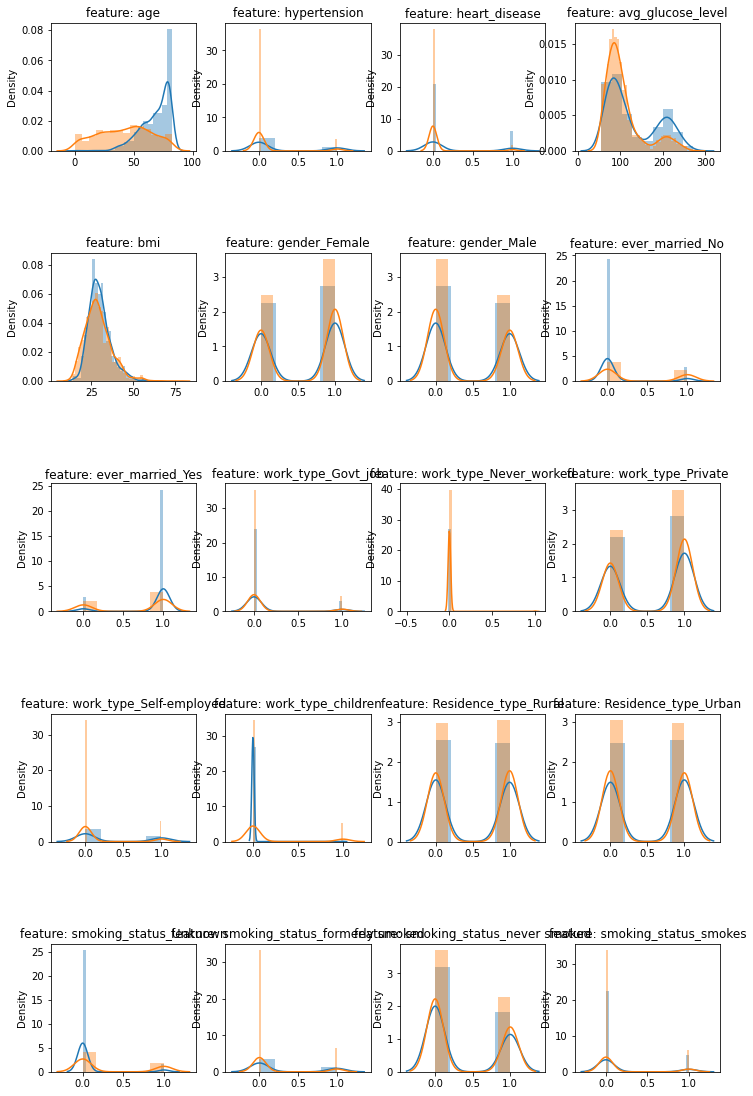

In [10]:
# Representamos gráficamente las características
features = df.drop("stroke", axis=1)

plt.figure(figsize=(12,32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(df[f][df["stroke"] == 1])
    sns.distplot(df[f][df["stroke"] == 0])
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(f))

plt.show()

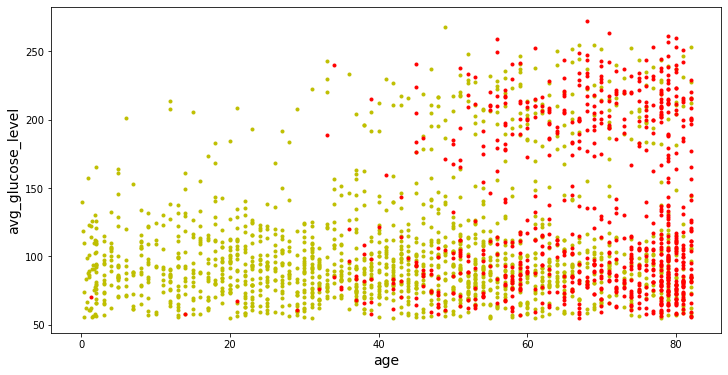

In [11]:
# Representación gráfica de dos características
plt.figure(figsize=(12, 6))
plt.scatter(df["age"][df['stroke'] == 0], df["avg_glucose_level"][df['stroke'] == 0], c="y", marker=".")
plt.scatter(df["age"][df['stroke'] == 1], df["avg_glucose_level"][df['stroke'] == 1], c="r", marker=".")
plt.xlabel("age", fontsize=14)
plt.ylabel("avg_glucose_level", fontsize=14)
plt.show()

## Kmeans con un conjunto de datos de dos dimensiones

In [12]:
X_2 = df[["age", "avg_glucose_level"]].copy()
y = df["stroke"].copy()
X_2

,age,avg_glucose_level
0,53.0,62.55
1,57.0,129.54
2,67.0,199.24
3,47.0,75.30
4,52.0,69.30
...,...,...
2378,80.0,84.86
2379,24.0,97.55
2380,31.0,108.89
2381,55.0,89.17


In [13]:
# Construcción de un pipeline para rellenar los valores nulos con la mediana y scalar los datos 
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('rbst_scaler', RobustScaler()),
    ])

In [14]:
# Rellenamos los valores nulos
X = num_pipeline.fit_transform(X_2)

In [15]:
# Transformamos el resultado a un DataFrame de Pandas
X = pd.DataFrame(X, columns=X_2.columns, index=y.index)

In [16]:
#Validamos que los cambios se aplicaron correctamente 
X

,age,avg_glucose_level
0,-0.027778,-0.658383
1,0.083333,0.729005
2,0.361111,2.172517
3,-0.194444,-0.394325
4,-0.055556,-0.518588
...,...,...
2378,0.722222,-0.196334
2379,-0.833333,0.066480
2380,-0.638889,0.301336
2381,0.027778,-0.107073


In [17]:
# Generamos los clusters para nuestro conjunto de datos sin etiquetar
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)

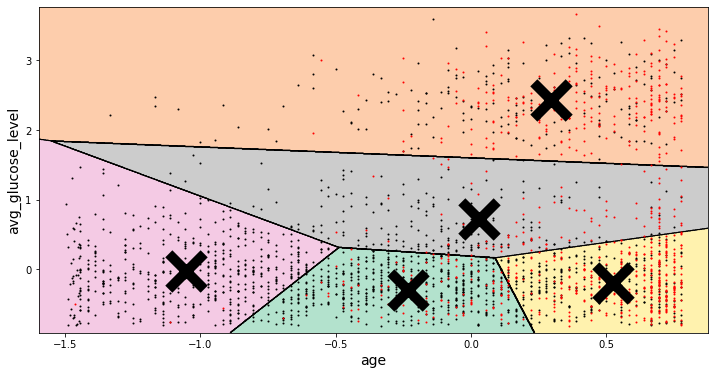

In [18]:
plt.figure(figsize=(12, 6))
plot_decision_boundaries(kmeans, X.values, df["stroke"].values)
plt.xlabel("age", fontsize=14)
plt.ylabel("avg_glucose_level", fontsize=14)
plt.show()

In [19]:
counter = Counter(clusters.tolist())
bad_counter = Counter(clusters[df['stroke'] == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are stroke samples".format(
        key, counter[key], bad_counter[key]))

Label 0 has 575 samples - 105 are stroke samples
Label 1 has 429 samples - 246 are stroke samples
Label 2 has 501 samples - 3 are stroke samples
Label 3 has 588 samples - 331 are stroke samples
Label 4 has 290 samples - 98 are stroke samples


## Kmeans con un conjunto de datos multidimensional

In [20]:
X_df = df.drop("stroke", axis=1)
y_df = df["stroke"].copy()

In [21]:
# Construcción de un pipeline para rellenar los valores nulos con la mediana y scalar los datos 
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('rbst_scaler', RobustScaler()),
    ])

In [22]:
# Rellenamos los valores nulos
X = num_pipeline.fit_transform(X_df)

In [23]:
# Transformamos el resultado a un DataFrame de Pandas
X = pd.DataFrame(X, columns=X_df.columns, index=y_df.index)

In [24]:
#Validamos que los cambios se aplicaron correctamente 
X

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,-0.027778,1.0,0.0,-0.658383,0.240506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,1.0,0.0,0.0,0.0
1,0.083333,1.0,0.0,0.729005,4.113924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.361111,1.0,1.0,2.172517,0.696203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.194444,0.0,0.0,-0.394325,-0.430380,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.055556,0.0,0.0,-0.518588,-1.050633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2378,0.722222,0.0,0.0,-0.196334,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,-1.0,1.0,1.0,0.0,0.0,0.0
2379,-0.833333,0.0,0.0,0.066480,-0.278481,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,1.0,0.0
2380,-0.638889,0.0,0.0,0.301336,3.025316,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,1.0,0.0,0.0,0.0
2381,0.027778,0.0,0.0,-0.107073,0.392405,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,1.0,0.0


In [25]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)

In [26]:
# Evaluamos los clusters y el contenido que se han formado
counter = Counter(clusters.tolist())
bad_counter = Counter(clusters[y_df == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are stroke samples".format(
        key, counter[key], bad_counter[key]))

Label 0 has 558 samples - 225 are stroke samples
Label 1 has 682 samples - 257 are stroke samples
Label 2 has 428 samples - 6 are stroke samples
Label 3 has 438 samples - 256 are stroke samples
Label 4 has 277 samples - 39 are stroke samples


## Reducción del número de características

### Aplicamos selección de características con _Random Forest_


In [27]:
# Utilizamos Random Forest para realizar selección de características
from sklearn.ensemble import RandomForestClassifier

clf_rnd = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
clf_rnd.fit(X, y_df)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [28]:
# Seleccionamos las características más importantes
feature_importances = {name: score for name, score in zip(list(X), clf_rnd.feature_importances_)}
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)

In [29]:
# Reducimos el conjunto de datos a las 7 características más importantes
X_reduced = X[list(feature_importances_sorted.head(5).index)].copy()

In [30]:
X_reduced

,age,avg_glucose_level,bmi,heart_disease,smoking_status_Unknown
0,-0.027778,-0.658383,0.240506,0.0,1.0
1,0.083333,0.729005,4.113924,0.0,0.0
2,0.361111,2.172517,0.696203,1.0,0.0
3,-0.194444,-0.394325,-0.430380,0.0,0.0
4,-0.055556,-0.518588,-1.050633,0.0,0.0
...,...,...,...,...,...
2378,0.722222,-0.196334,0.000000,0.0,1.0
2379,-0.833333,0.066480,-0.278481,0.0,0.0
2380,-0.638889,0.301336,3.025316,0.0,1.0
2381,0.027778,-0.107073,0.392405,0.0,0.0


### Entrenamiento de KMEANS con el conjunto de datos reducido

In [31]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_reduced)

In [32]:
# Evaluamos los clusters y el contenido que se han formado
counter = Counter(clusters.tolist())
bad_counter = Counter(clusters[y_df == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are stroke samples".format(
        key, counter[key], bad_counter[key]))

Label 0 has 644 samples - 332 are stroke samples
Label 1 has 447 samples - 256 are stroke samples
Label 2 has 415 samples - 6 are stroke samples
Label 3 has 194 samples - 32 are stroke samples
Label 4 has 683 samples - 157 are stroke samples


## Evaluación de los resultados

In [33]:
# Calculamos el purity score, es importante darse cuenta de que recibe las etiquetas
print("Purity Score:", purity_score(y_df, clusters))

Purity Score: 0.7070919009651699


In [34]:
# Calculamos el coeficiente de Shiloutte, es importante darse cuenta de que no le pasamos las etiquetas
print("Shiloutte: ", metrics.silhouette_score(X_reduced, clusters, sample_size=10000))

Shiloutte:  0.2766659425332636


In [35]:
# Calculamos el Calinski harabasz score, es importante darse cuenta de que no le pasamos las etiquetas
print("Calinski harabasz: ", metrics.calinski_harabasz_score(X_reduced, clusters))

Calinski harabasz:  1193.3656886974727
